<h1><b>Movie Genre Analysis

---




<details>
<summary><b>Check out my other projects!</b></summary>
Links to other projects here

<h3><b> Background </b></h3>

In this section I conducted an analysis of the relationship between overview text and movie genre in the imdb dataset. The use case is to predict the correct genre for a movie whose description of the overview is provided.


<b>[OpenAI](https://openai.com)</b>
> Quote1
Quote..................... sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss



In [ ]:
!wget "https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/movies_metadata.csv"

--2024-11-12 02:03:38--  https://raw.githubusercontent.com/lexie21/recommender/main/model/movies_data/imdb_folder/movies_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34445126 (33M) [text/plain]
Saving to: ‘movies_metadata.csv’

movies_metadata.csv 100%[===================>]  32.85M  12.7MB/s    in 2.6s    

2024-11-12 02:03:41 (12.7 MB/s) - ‘movies_metadata.csv’ saved [34445126/34445126]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Goal: focusing on all things tokenizing and embedding alone

In [ ]:
data = pd.read_csv("movies_metadata.csv")

In [ ]:
data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
# first task is genre prediction through overview only so extract original title, language, overview, tagline,id,genres
df = data[["original_title","original_language","overview","id","genres"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_title     45466 non-null  object
 1   original_language  45455 non-null  object
 2   overview           44512 non-null  object
 3   id                 45466 non-null  object
 4   genres             45466 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [ ]:
# check na in overview => drop these
print(df.shape[0])
print(f"NA values in overview: {df[df['overview'].isnull()].shape[0]/df.shape[0]:.3f}%")
df = df[df["overview"].notnull()]
print(df.shape[0])

45466
NA values in overview: 0.021%
44512


In [ ]:
# check na in language => drop
print(df[df["original_language"].isnull()].shape[0])
df = df[df["original_language"].notnull()]
print(df.shape[0])

10
44502


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44502 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_title     44502 non-null  object
 1   original_language  44502 non-null  object
 2   overview           44502 non-null  object
 3   id                 44502 non-null  object
 4   genres             44502 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [ ]:
# metrics: length of overview(word) by genre - boxplot, genre distribution (how many for each movie) - barplot
df["genres"]

,genres
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'id': 35, 'name': 'Comedy'}]"
...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
45462,"[{'id': 18, 'name': 'Drama'}]"
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
45464,[]


In [ ]:
def destring(var):
      df_ = df.copy()
      def generate_list(x):
          if isinstance(x, list):
              names = [i["name"] for i in x]
              return names
          return []

      def sanitize(x):
          if isinstance(x, list):
              return [str.lower(i.replace(" ", "")) for i in x]
          else:
              if isinstance(x, str):
                  return str.lower(x.replace(" ", ""))
              else:
                  return ''

      df_[var] = df_[var].fillna('[]').apply(literal_eval)
      df_[var] = df_[var].apply(generate_list).apply(sanitize)
      return df_

In [ ]:
df_final = destring("genres")
df_final.head()

,original_title,original_language,overview,id,genres
0,Toy Story,en,"Led by Woody, Andy's toys live happily in his ...",862,"[animation, comedy, family]"
1,Jumanji,en,When siblings Judy and Peter discover an encha...,8844,"[adventure, fantasy, family]"
2,Grumpier Old Men,en,A family wedding reignites the ancient feud be...,15602,"[romance, comedy]"
3,Waiting to Exhale,en,"Cheated on, mistreated and stepped on, the wom...",31357,"[comedy, drama, romance]"
4,Father of the Bride Part II,en,Just when George Banks has recovered from his ...,11862,[comedy]


In [ ]:
# check distribution of the 1-genre to see if its representative, will do
df_final[df_final["genres"].apply(lambda x: len(x) == 1)]["genres"].value_counts()

,count
genres,
[drama],4910
[comedy],3371
[documentary],2682
[horror],971
[thriller],455
[western],317
[action],276
[animation],236
[sciencefiction],195


In [ ]:
df_cut = df_final[df_final["genres"].apply(lambda x: len(x) == 1)]
df_cut["genres"] = df_cut["genres"].apply(lambda x: x[0])
df_cut = df_cut[df_cut["genres"]!="tvmovie"]
df_cut.shape[0]

14127

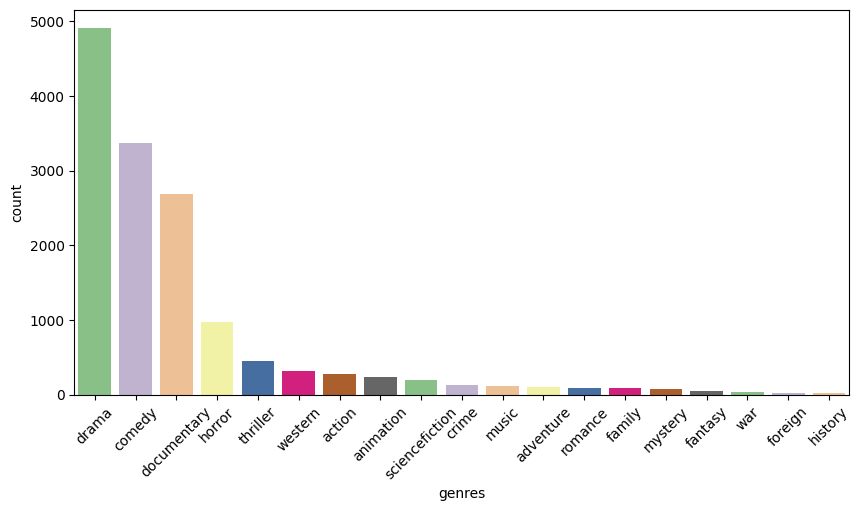

In [ ]:
# counts by genre
plt.figure(figsize=(10,5))
sns.barplot(data=df_cut["genres"].value_counts().reset_index(),x="genres",y="count",palette="Accent")
plt.xticks(rotation=45);

In [ ]:
# check the one with NO overview => drop
print(df_cut.shape[0])
df_cut = df_cut[df_cut["overview"].apply(lambda x: not x.lower().startswith("no overview"))]
print(df_cut.shape[0])

14127
14056


In [ ]:
# ones with <= 2 words? drop id 49788, 47110, 115239
df_cut = df_cut[df_cut["id"].apply(lambda x: int(x) not in [49788,47110,115239])]

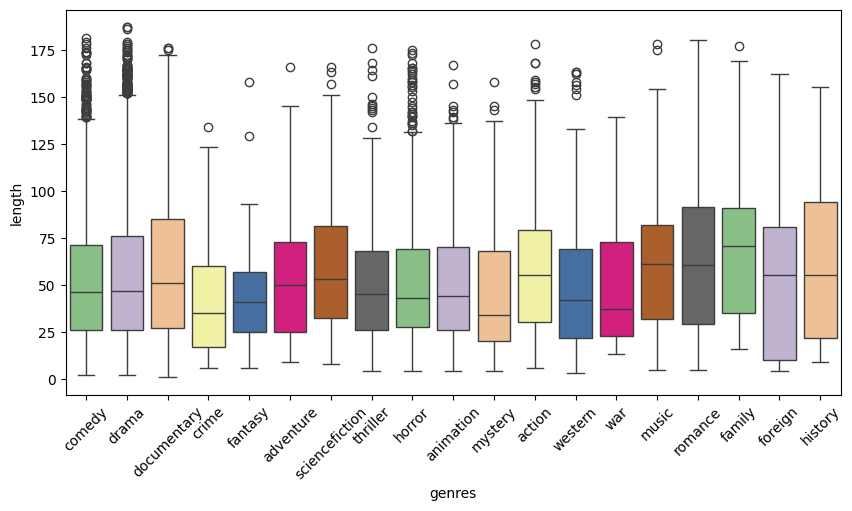

In [ ]:
# length of words in overview by genres
plt.figure(figsize=(10,5))
# df_cut["length"] = df_cut["overview"].apply(lambda x: len(x.split(" ")))
sns.boxplot(df_cut,x="genres",y="length",palette="Accent")
plt.xticks(rotation=45);

In [ ]:
# label_enc = LabelBinarizer()
# label_df = label_enc.fit_transform(df_cut["genres"])
# merged_df = pd.merge(df_cut,pd.DataFrame(label_df,columns=label_enc.classes_),left_index=True,right_index=True)
# merged_df.head()

In [ ]:
# label encoder - integer class for fitting log reg
label_enc2 = LabelEncoder()
target = label_enc2.fit_transform(df_cut["genres"])
target

array([ 3,  6,  6, ..., 11, 15,  6])

In [ ]:
df_cut["target"] = target

In [ ]:
# merged_df.drop('index',axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_cut["overview"],target,random_state=110598, test_size=0.2,stratify=target)

In [ ]:
tfidf = TfidfVectorizer(analyzer="word",min_df=1,strip_accents='unicode',token_pattern=r'\w{1,}', use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words='english')
overview_embedding = tfidf.fit_transform(X_train)
overview_embedding.shape

(11242, 39021)

In [ ]:
tfidf.get_feature_names_out()[1000:1100]

array(['aerial', 'aero', 'aerobics', 'aeronautics', 'aeroplane',
       'aerospace', 'aesthete', 'aesthetic', 'aesthetically',
       'aesthetics', 'afar', 'afeta', 'affable', 'affably', 'affair',
       'affaires', 'affairs', 'affect', 'affected', 'affecting',
       'affection', 'affectionate', 'affectionately', 'affections',
       'affects', 'affiches', 'affiliate', 'affiliation', 'affinity',
       'affirmative', 'affittata', 'affleck', 'afflict', 'afflicted',
       'afflicting', 'affliction', 'afflictions', 'affluent', 'afford',
       'affordability', 'affordable', 'afforded', 'affords', 'affronte',
       'afghan', 'afghani', 'afghanistan', 'afi', 'afield', 'afin',
       'afire', 'afk', 'afkomstig', 'aflame', 'afloat', 'afoot',
       'aforementioned', 'afoul', 'afraid', 'afresh', 'africa',
       'africaine', 'african', 'africans', 'afrikaner', 'afro',
       'afrobeat', 'afshar', 'afshin', 'aftereffects', 'afterlife',
       'aftermath', 'afternoon', 'afternoons', 'afterwar

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15): # implemented by https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py
    """
    actual: 1d array
    predicted: matrix of shape nrow x nclasses
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [ ]:
clf = LogisticRegression(multi_class='ovr',max_iter=200)
clf.fit(overview_embedding,y_train)

LogisticRegression(max_iter=200, multi_class='ovr')

In [ ]:
Xtest_embedding = tfidf.transform(X_test)
pred_probs = clf.predict_proba(Xtest_embedding)

In [ ]:
pred_probs.shape

(2811, 19)

In [ ]:
multiclass_logloss(y_test,pred_probs)

1.290574319436577

In [ ]:
preds = clf.predict(Xtest_embedding)
(preds == y_test).mean() # why suddenly did this well?

0.6286019210245464

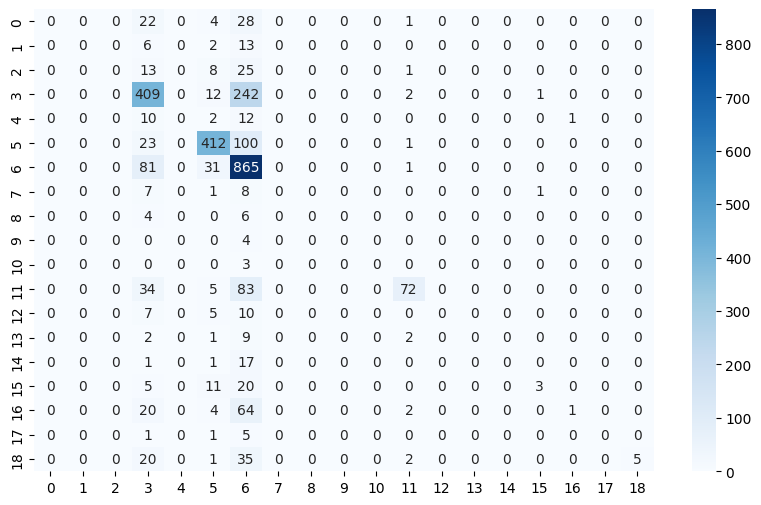

In [ ]:
plt.figure(figsize=(10,6))
cm = confusion_matrix(y_test,clf.predict(Xtest_embedding))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True); # redraw this to show percentage as well

We now improve the embeding to achieve better result. First, we'll use the tiktoken library to generate token and just keep it as a one-hot embedding matrix without accounting for sequentiality. Later we'll optimize the embeddings using encoder-based transformer to predict the genres and finally we just use BERT. -- rewrite

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.6 MB/s eta 0:00:00


In [ ]:
# GPT-4 (merges spaces)
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("  졸리다"))

[220, 3396, 94, 116, 29102, 13447]


In [ ]:
# test encoder on our corpus, 11 looks like a comma
tokenized = [enc.encode(text) for text in X_train.values[:3]]
for i, text in enumerate(tokenized):
  print(f"Text: {X_train.values[i]}")
  print(f"Tokens: {tokenized[i]}\n")

Text: Incisive comic Jen Kirkman gets real about women's bodies, the value of alone time and an Italian private tour guide who may have been a ghost.
Tokens: [40345, 285, 535, 20303, 25937, 32446, 1543, 5334, 1972, 922, 3278, 596, 13162, 11, 279, 907, 315, 7636, 892, 323, 459, 15155, 879, 7364, 8641, 889, 1253, 617, 1027, 264, 20457, 13]

Text: The Pope is disturbed by the fact that today's youth are not as spiritually inclined as they should be, and so he decides to set up a Vatican television station and entice them back into the religion of their ancestors. In order to particularly grab the wandering flock, a priest invites the comedians from "The Other Sunday," an actual comedy program on Italian television, to perform on this new channel. He sets up a show that parodies an over-the-hill transvestite group, the Flagg Sisters, played by themselves. This understandably upsets one of the more eminent Cardinals who tries every means he can to stop the show. Nothing succeeds, and he can

In [ ]:
from itertools import chain
flattened = list(chain.from_iterable(tokenized))
print(len(flattened))
print(len(list(set(flattened)))) # vocab size for the first 3 examples = 214

244
170


In [ ]:
train_tokenized = [enc.encode(text) for text in X_train.values]

In [ ]:
test_tokenized = [enc.encode(text) for text in X_test.values]

In [ ]:
for i, text in enumerate(test_tokenized[:3]):
  print(f"Text: {X_test.values[i]}")
  print(f"Tokens: {test_tokenized[i]}\n") # 374 seems to be "is"

Text: "Master Harold" is what the black employees are ordered to call young Hally, the son of a well-to-do white couple who own a fashionable tea room. Hally wanders into the establishment one day and sees two black male workers practicing for an upcoming ballroom competition by dancing together. The two employees and Hally exchange kidding rebukes, not meant to offend anyone. But after Hally receives some bad news about his father, he takes out his anger upon the workers. Efforts to smooth out the situation erupt into an all-out racial conflict.
Tokens: [1, 18532, 53215, 1, 374, 1148, 279, 3776, 8420, 527, 11713, 311, 1650, 3995, 473, 750, 11, 279, 4538, 315, 264, 1664, 4791, 30659, 4251, 5743, 889, 1866, 264, 60423, 15600, 3130, 13, 473, 750, 29810, 388, 1139, 279, 21967, 832, 1938, 323, 16008, 1403, 3776, 8762, 7487, 36666, 369, 459, 14827, 5041, 3039, 10937, 555, 29066, 3871, 13, 578, 1403, 8420, 323, 473, 750, 9473, 56825, 12646, 65850, 11, 539, 8967, 311, 85086, 5606, 13, 2030, 1

In [ ]:
len(train_tokenized), len(test_tokenized)

(11242, 2811)

In [ ]:
flattened = list(chain.from_iterable(train_tokenized + test_tokenized)) # both set's vocab
print(len(flattened))
vocab_size = len(list(set(flattened)))
print(vocab_size)
vocab_size = vocab_size + 2# 1 for <PAD> and 1 for <CLS>
print(vocab_size) # vocab size for the first 3 examples = 34004, 4k smaller than tfidf's

986245
36220
36222


In [ ]:
# construct the one-hot matrix of shape (corpus size, vocab size) only to show frequency, can't train sth this sparse
itok = {idx:token for idx,token in enumerate(pd.Series(flattened).sort_values().unique().tolist())}
itok[vocab_size-2] = "<PAD>"
itok[vocab_size-1] = "<CLS>"
toki = {token:idx for idx, token in itok.items()}

In [ ]:
hold = []
for text in train_tokenized:
  hold.append([toki["<CLS>"]] + [toki[tok] for tok in text])

In [ ]:
# do same thing for test set
test_hold = []
for text in test_tokenized:
  test_hold.append([toki["<CLS>"]] + [toki[tok] for tok in text])

In [ ]:
corpus_size = len(list(set(flattened))) # stats of train set
embedding_trainmat = np.zeros((len(train_tokenized),corpus_size)) # then imshow this by genre
for i, text in enumerate(train_tokenized):
  if i % 1000 == 0:
    print(i)
  for tok in text:
    embedding_trainmat[i,toki[tok]] += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [ ]:
# quick sanity test
print(len(train_tokenized[0]))
print(embedding_trainmat[0,:].sum())

32
32.0


In [ ]:
trainmat = pd.DataFrame(embedding_trainmat,columns=pd.Series(flattened).sort_values().unique())
trainmat.shape

(11242, 36220)

In [ ]:
trainmat["genre"] = y_train
aggs = trainmat.groupby("genre").sum().reset_index().set_index("genre") # mean?

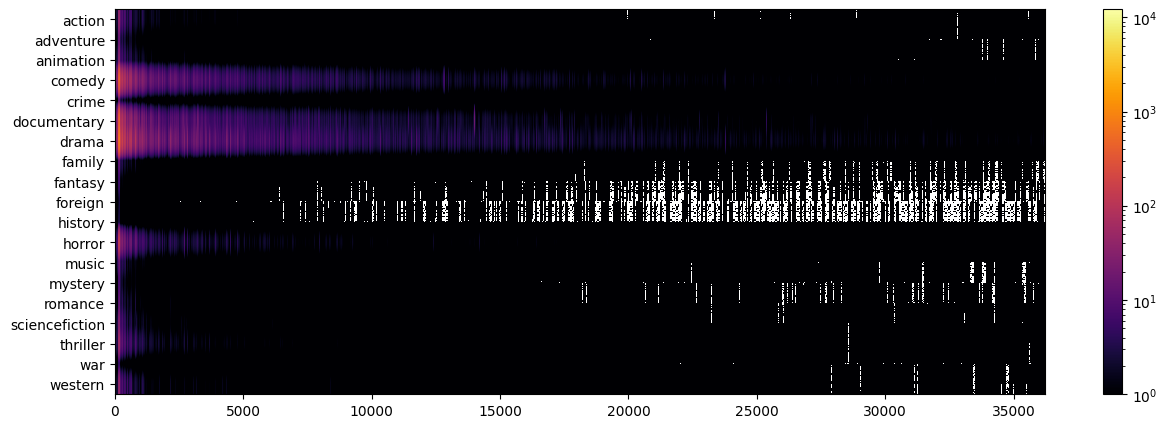

In [ ]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15,5))
plt.imshow(aggs,aspect="auto",cmap="inferno",norm=LogNorm(vmin=1, vmax=12165))
plt.colorbar()
plt.yticks(ticks=np.arange(0,label_enc2.classes_.shape[0]),labels=label_enc2.classes_);
# white is 0, comedy, drama and documentary are most expressive in token space corresponding to the boxplot above
# the less "expressive" are fantasy, tvmovie, war

In [ ]:
# check what the brightest tokens are => this shows up a lot almost univerally in all genres, also class imbalance

In [ ]:
# skip over the embedding step now and use sentence bert, we'll train the model from scratch later
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
trans_embeddings = model.encode(X_train.values)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
trans_embeddings.shape

(11247, 384)

In [ ]:
logreg2 = LogisticRegression()
logreg2.fit(trans_embeddings,y_train)

LogisticRegression()

In [ ]:
test_embeddings = model.encode(X_test.values)

In [ ]:
(logreg2.predict(test_embeddings) == y_test).mean()

0.6386913229018493

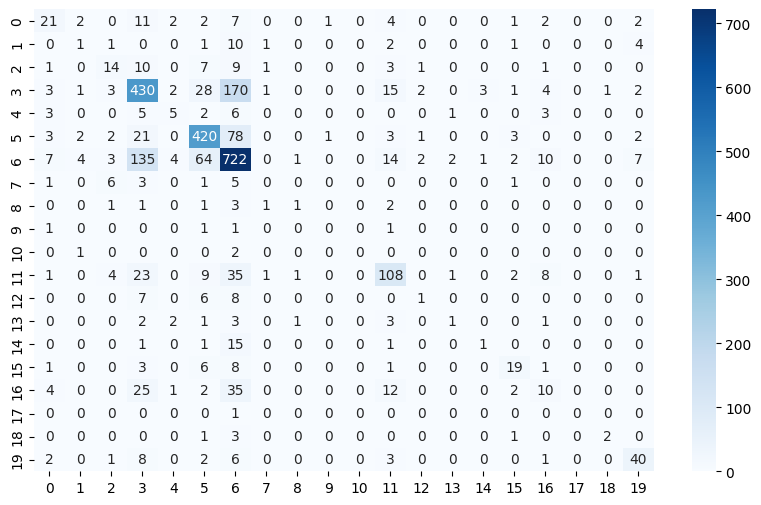

In [ ]:
plt.figure(figsize=(10,6))
cm2 = confusion_matrix(y_test,logreg2.predict(test_embeddings))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=True);

In [ ]:
# train our own embeddings for the task: put through encoder-based transformer = no masking, repeat for n layers, backprop and use the final hidden presentation as embeddings
# also let final n_embed = 384 like above. Also, we stick to logistic regression so no need to add the CLS token.... added :)
import torch.nn as nn
import torch
from torch.nn import functional as F

In [ ]:
block_size = pd.Series([len(tok) for tok in hold]).max() # no text excedes the token limit for one sequence
block_size

418

ToDo:
- Masking: just broadcasting, but add condition, row i = 0 if token i = 0 in the original mask. original mask = BxT, broadcasted masks = BxTxT.
- Optimize embedding to predict genre, only use train set.
- last approach: fine-tune the pretrained language model.
summarize in readme.

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, q,k,v, mask=None):
    scores = q@k.transpose(-1,2) * (1.0/np.sqrt(k.size(-1)))
    if mask != None:
      scores = scores.masked_fill(mask==False, float("-inf"))
      # check if this is working properly
    weights = F.softmax(scores,dim=-1)
    attention_value = weights @ v
    return attention_value

class MultiHeadAttention(nn.Module):
  def __init__(self,n_embed, num_head):
    super().__init__()

    assert n_embed % num_head == 0, "verify if n_embed is divisible by num_head"
    self.num_head = num_head
    self.head_size = n_embed//num_head
    self.scores = ScaledDotProductAttention()
    self.q = nn.Linear(n_embed, n_embed)
    self.k = nn.Linear(n_embed, n_embed)
    self.v = nn.Linear(n_embed, n_embed)

  def forward(self,q,k,v,mask=None):
    B,T = q.shape[:-1]
    q = self.q(q)
    k = self.k(k)
    v = self.v(v)
    q = q.view(B,T,self.num_head, self.head_size).transpose(1,2) # B,nh,T,head_size
    k = k.view(B,T,self.num_head, self.head_size).transpose(1,2)
    v = v.view(B,T,self.num_head, self.head_size).transpose(1,2)
    output = self.scores(q,k,v,mask)
    output = output.transpose(1,2).contiguous().view(B,T,self.num_head*self.head_size)
    return output

class FF(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.fc1 = nn.Linear(n_embed, 4*n_embed)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(4*n_embed, n_embed)
    # self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

class Masking(nn.Module): # done padding
  def __init__(self,padding_idx=vocab_size-2, max_len=block_size): # padding
    super().__init__()
    self.max_len = max_len
    self.pad_token = padding_idx

  def forward(self, x): # x is a list
    with torch.no_grad():
      x_padded = [seq + [self.pad_token] * (self.max_len - len(seq)) for seq in x]
      x_padded = torch.tensor(x_padded)
      B,T = x_padded.shape
      mask = (x_padded != self.pad_token) # returns bool
      mask_broadcasted = mask.unsqueeze(1).expand(B,T,T) # T masks of shape BxT
      mask_cond = mask_broadcasted.clone() # refactor later
      ridx, cidx = torch.where(mask == False)
      conditions = torch.stack((ridx, cidx), dim=1)

      for cond in conditions:
        mask_cond[cond[0],cond[1],:] = False
    return x_padded, mask_cond.view(B,1,T,T) # need to have shape B,nh,T,T?

class EncoderLayer(nn.Module): # communication and computation
  def __init__(self, n_embed, num_head, drop_prob):
    super().__init__()
    self.self_attention = MultiHeadAttention(n_embed, num_head)
    self.ffwd = FF(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self,enc): # duplicate k and v here or what? just do the same thing first and change later
    enc = self.ln1(enc + self.self_attention(enc,enc,enc))
    enc = self.ln2(enc + self.ffwd(enc))
    return enc

class Encoder(nn.Module):
  def __init__(self, drop_prob=0, n_embed=384,n_layers=3,vocab_size=vocab_size,num_head=4, max_len=block_size, padding_idx=vocab_size-2): # add device,drop_prob later
    super().__init__()
    self.max_len = max_len
    self.token_padding = Masking(padding_idx = padding_idx)
    self.token_embedding = nn.Embedding(vocab_size, n_embed, padding_idx = padding_idx)
    print(f"Vocab size: {self.token_embedding.num_embeddings}")
    self.positional_embedding = nn.Embedding(max_len, n_embed)
    self.blocks = nn.ModuleList([EncoderLayer(n_embed, num_head, drop_prob) for _ in range(n_layers)])
    self.ln = nn.LayerNorm(n_embed) # final layer norm
    self.enc_cls = nn.Linear(n_embed, label_enc2.classes_.shape[0]) # don't have to care about masking here becos does not affect directly

  def forward(self, idx, targets=None):
    idx, mask = self.token_padding(idx)
    tok_emb = self.token_embedding(idx)

    pos_emb = self.positional_embedding(torch.arange(self.max_len, device=device))
    x = tok_emb + pos_emb

    for block in self.blocks:
      x = block(x)

    x = self.ln(x) # B,T,C only take the first t
    x_cls = x[:,0,:]
    logits = self.enc_cls(x_cls)
    if targets == None:
      loss = None
    loss = F.cross_entropy(logits, targets)
    return logits, loss

In [ ]:
mask_test = [[1,2,4],[5,6,3,2,7],[5,4,2,6,5,47]]
m = Masking(max_len = 7)
play = m(mask_test)
play[1]

tensor([[[[ True,  True,  True, False, False, False, False],
          [ True,  True,  True, False, False, False, False],
          [ True,  True,  True, False, False, False, False],
          [False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False]]],


        [[[ True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True, False, False],
          [False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False]]],


        [[[ True,  True,  True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True,  True, False],
          [ True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # gpu won't work now :D
model = Encoder().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

In [ ]:
def get_batch(split,batch_size=32):
  # list so a bit inefficient, consider putting this after padding
  dat_x = hold if split == "train" else test_hold
  dat_y = y_train if split == "train" else y_test
  idx = np.random.randint(0, len(dat_x),size=batch_size)
  batch = [dat_x[i] for i in idx]
  batch_target = dat_y[idx]
  return batch, batch_target

In [ ]:
y = torch.tensor(target[200:300])
x = hold[200:300]
for i in range(10):
  logs, loss = model(x,y)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()
  print(loss.item()) # successfully overfitted a batch

2.7295119762420654
3.958966016769409
3.4411816596984863
2.311124324798584
1.9896910190582275
2.1206881999969482
2.071389675140381
1.9365599155426025
1.8786790370941162
1.8852561712265015


In [ ]:
model = Encoder().to(device)
print(sum(param.numel() for param in model.parameters())/1e6, 'M params')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
n_iters = 200
interval = 20
for i in range(n_iters):
  if i % interval == 0 or i == n_iters - 1:
    with torch.no_grad():
  #     out = {}
      model.eval()
  #     for split in ['train','test']:
  #       losses = torch.zeros(n_iters)
  #       for j in range(n_iters):
      xb, yb = get_batch('test')
      print(xb)
      logits, loss = model(xb, yb)
      print(f"Test loss: {loss.item()}")
  #         losses[j] = loss.item()
  #       out[split] = losses.mean()
  #     model.train()
  #     print(out)
  xb, yb = get_batch('train')
  logits, loss = model(xb,yb)
  if i % interval == 0 or i == n_iters - 1:
    print(loss.item())
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


Vocab size: 36222
18.957715 M params
[[36221, 27, 9014, 406, 3901, 9, 1965, 152, 632, 3324, 334, 14636, 2190, 19285, 177, 28029, 9, 2493, 294, 12451, 8286, 9, 653, 4037, 6610, 3515, 833], [36221, 444, 127, 18130, 17815, 8875, 1031, 3075, 3517, 7368, 1282, 9, 16170, 377, 23078, 1264, 788, 1685, 162, 127, 2320, 1416, 9, 11652, 1372, 997, 11739, 177, 644, 350, 3776, 260, 1416, 799, 654, 746, 11, 2143, 9950, 168, 2564, 788, 19811, 5822, 177, 141, 22112, 172, 141, 938, 1613, 788, 162, 127, 14837, 645, 268, 4405, 18845, 177, 600, 132, 2922, 11], [36221, 32636, 3394, 340, 625, 3903, 162, 294, 1709, 9, 13658, 14471, 23880, 217, 127, 9409, 5979, 14879, 11, 11554, 745, 333, 141, 3465, 1399, 374, 127, 7622, 14607, 9, 9254, 5195, 3617, 1136, 2516, 141, 1396, 177, 598, 374, 598, 582, 16592, 11], [36221, 27, 12799, 16219, 235, 1029, 1376, 3394, 9, 8559, 177, 1173, 4882, 9, 644, 3119, 168, 6741, 3285, 7231, 162, 629, 4360, 959, 8559, 3675, 11848, 177, 493, 127, 5845, 11], [36221, 27, 20404, 919, 6204

In [ ]:
# evaluate

In [ ]:
# evaluate on the entire test set
# predictions = model(test_hold)[0].argmax(dim=1)
# (predictions == y_test).mean()

In [ ]:
plt.figure(figsize=(10,6))
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True);

# Ignore the section below

In [ ]:
df_final["genres_count"] = df_final["genres"].apply(len)
df_final["overview_len"] = df_final["overview"].apply(lambda x: len(x.split(" ")))

NameError: name 'df_final' is not defined

In [ ]:
# check no genre movies => drop
print(df_final.shape[0])
print(f"No of 0 genre movies: {df_final[df_final['genres_count'] == 0].shape[0]/df_final.shape[0]:.3f}%")
df_final = df_final[df_final["genres_count"] > 0]
print(df_final.shape[0])

NameError: name 'df_final' is not defined

In [ ]:
# df_final.reset_index(inplace=True)
# df_final.drop('index',axis=1,inplace=True)

In [ ]:
# distribution of genres_count, length by genres_count
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.histplot(df_final, x="genres_count",ax=axes[0],color="lightblue")
axes[0].set_title("# of genres for each movie")
sns.boxplot(df_final,x="genres_count",y="overview_len",color="lightblue",ax=axes[1])
axes[1].set_title("Length of overview by counts of genre");

In [ ]:
# vectorize genres
encoder = MultiLabelBinarizer()
encoded = encoder.fit_transform(df_final["genres"])
encoded_df = pd.DataFrame(encoded,columns=encoder.classes_)
encoded_df.head()

In [ ]:
df_merged = df_final.copy()
df_merged = pd.merge(df_final, encoded_df, left_index=True, right_index=True)

NameError: name 'df_final' is not defined

In [ ]:
df_merged.head()

In [ ]:
# distribution of genres, multilabel allowed
encoder.classes_

In [ ]:
drop_genres = []
for cls in encoder.classes_:
  count = df_merged[cls].sum(axis=0)
  if count == 1:
    print(f"{cls}: dropped")
    drop_genres.append(cls)
  elif count != 1:
    print(f"{cls}: {count}, {count/df_merged.shape[0]:.3f}%")

In [ ]:
drop_genres

In [ ]:
df_merged.drop(drop_genres,axis=1,inplace=True)

In [ ]:
gen_df = [cls for cls in encoder.classes_ if cls not in drop_genres]
counts = [df_merged[gen].sum(axis=0) for gen in gen_df]
gen_df = pd.DataFrame({'genre':gen_df,'counts':counts})

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(gen_df.sort_values(by='counts',ascending=False),x='genre',y='counts',color='lightpink',edgecolor='black')
plt.xticks(rotation=45)
plt.title("Distribution of genres"); # class imbalance problem

In [ ]:
# what genres usually go together? focus on the most common genre = drama
df_merged[gen_df["genre"]].corr()["drama"].sort_values(ascending=False)[1:6]

In [ ]:
df_merged[gen_df["genre"]].corr()["action"].sort_values(ascending=False)[1:6]

In [ ]:
df_merged[gen_df["genre"]].corr()["comedy"].sort_values(ascending=False)[1:5]

Tokenization and Embedding

In [ ]:
# total original vocab
from itertools import chain
flattened = list(chain.from_iterable(df_merged["overview"].apply(lambda x: x.split(" ")).tolist()))
print(len(flattened))
print(len(list(set(flattened)))) # before accpunting for stopwords?

In [ ]:
# tfidf, use this as baseline benchmark
tfidf = TfidfVectorizer(analyzer="word",min_df=1,strip_accents='unicode',token_pattern=r'\w{1,}', use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words='english')
overview_embedding = tfidf.fit_transform(df_merged["overview"])
overview_embedding.shape # too big

In [ ]:
tfidf.get_feature_names_out()[10100:10200]

Loss function: multilabel log loss

In [ ]:
def multilabel_logloss(y_true, y_pred):
  y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
  log_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
  return log_loss

In [ ]:
# on average, logloss for 1 observation is ?
print(f"No of classes: {gen_df.shape[0]}")
print(f"Initial loss guess: {-np.log(1/gen_df.shape[0])}")

Fit logistic regression on input embeddings

In [ ]:
for genr in gen_df["genre"].values:
  print(f"{genr}: {df_merged[genr].sum(axis=0)}")

In [ ]:
# split data
X = overview_embedding
y = df_merged[gen_df['genre'].values]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=110598) # cant use stratify due to imbalance class

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
# check distribution of genres in 2 datasets
def genre_dist(data):
  for genre in data.columns:
    print(f"{genre}: {data[genre].sum(axis=0)}, {data[genre].sum(axis=0)/data.shape[0]:.3f}%")

In [ ]:
genre_dist(y_train)

In [ ]:
genre_dist(y_test)

In [ ]:
# logistic regression
clf = MultiOutputClassifier(LogisticRegression())
clf.fit(X_train,y_train)
predictions = np.array(clf.predict_proba(X_test))[:,:,1].transpose()
print(f"logloss: {multilabel_logloss(y_test,predictions):.3f}")

In [ ]:
# apply SVD to reduce to 120 components for our embeddings
svd = TruncatedSVD(n_components=120)
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

scl = StandardScaler()
scl.fit(X_train_svd)
X_train_scl = scl.transform(X_train_svd)
X_test_scl = scl.transform(X_test_svd)

NameError: name 'TruncatedSVD' is not defined

In [ ]:
print(X_train_scl.shape, X_test_scl.shape)

In [ ]:
# embedding distribution for the first 100 overviews, most are close to 0
plt.imshow(X_train_scl[:100,:],cmap='viridis')
plt.colorbar();

In [ ]:
# do this later for BERT-produced embeddings
# 2d embedding
svd_2d = TruncatedSVD(n_components=2)
X_train_svd2d = svd_2d.fit_transform(X_train)

# plot the first 50 titles
x,y = X_train_svd2d[:50,0], X_train_svd2d[:50,1]
plt.scatter(x,y,alpha=0.7)
for i, label in enumerate(df_merged["original_title"][:50]):
    plt.text(x[i], y[i], label, ha='right', va='bottom', fontsize=10, color='black',alpha=0.5);

In [ ]:
# reapply logistic regression
clf = MultiOutputClassifier(LogisticRegression())
clf.fit(X_train_scl,y_train)
predictions = np.array(clf.predict_proba(X_test_scl))[:,:,1].transpose()
print(f"logloss: {multilabel_logloss(y_test,predictions):.3f}")

In [ ]:
# xgboost on lower dim data
clf = MultiOutputClassifier(XGBClassifier(max_depth=7, n_estimators=150,colsample_bytree=0.8,subsample=0.8,learning_rate=0.1))
clf.fit(X_train_scl,y_train)
predictions = np.array(clf.predict_proba(X_test_scl))[:,:,1].transpose()
print(f"logloss: {multilabel_logloss(y_test,predictions):.3f}")

In [ ]:
# multilabel classification metrics, but need to determine decision threshold before that
# for this problem, manually divide into N-genre classes and pick the top N probabilities and see if the true class is one of them
prob_threshold = pd.DataFrame(predictions).apply(lambda x: np.sort(x.values)[::-1][4],axis=1)
y_preds = np.where(predictions > prob_threshold.to_numpy().reshape(-1,1),1,0)

In [ ]:
def Ngenre_metric(N):
  subdf = y_test.apply(lambda x: x.sum()==N,axis=1)
  prob_threshold = pd.DataFrame(predictions).apply(lambda x: np.sort(x.values)[::-1][N-1],axis=1)
  y_preds = np.where(predictions > prob_threshold.to_numpy().reshape(-1,1),1,0)
  print(f"hamming loss: {hamming_loss(y_test,y_preds):.3f}")
  print(f"subset accuracy: {accuracy_score(y_test,y_preds)*100:.3f}%")
  print(f"f1 score: {f1_score(y_test, y_preds, average='weighted'):.3f}")

In [ ]:
for n in range(1,9):
  print(f"Metrics for the {n}-genre group")
  Ngenre_metric(n)
  print(" ")

Possible explanation for the model's terrible performance:
- Imbalanced class distribution - consider grouping the highly correlated genres into 1, but this risks losing a lot of information
- Multilabel complexity: dependency - use chained classifier if stick to logistic regresison, else migrate to transformer completely
- Failure to capture information from text: better text tokenization and embedding, use BERT-like encoder to vectorize the overviews

However, I decide to not move forward at this step due to the limited usability of this project. For example, LLM can already predict the genre very accurately when you provide it with a madeup overview. Furthermore, nowadays you don't need to know the genre in order to recommend what movies a new use will like anymore. Comparing between the overview texts themselves usually suffices.